In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [2]:
products = pd.DataFrame([
    {"product_id": 101, "name": "Wireless Mouse", "category": "Electronics",
     "description": "Ergonomic wireless mouse with USB receiver."},
    {"product_id": 102, "name": "Bluetooth Headphones", "category": "Electronics",
     "description": "Noise-cancelling over-ear Bluetooth headphones."},
    {"product_id": 103, "name": "Coffee Maker", "category": "Home Appliances",
     "description": "Automatic drip coffee maker with timer function."},
    {"product_id": 104, "name": "Running Shoes", "category": "Sports",
     "description": "Lightweight running shoes with breathable mesh."},
    {"product_id": 105, "name": "Yoga Mat", "category": "Fitness",
     "description": "Non-slip yoga mat with carrying strap, extra comfort."}
])

products


,product_id,name,category,description
0,101,Wireless Mouse,Electronics,Ergonomic wireless mouse with USB receiver.
1,102,Bluetooth Headphones,Electronics,Noise-cancelling over-ear Bluetooth headphones.
2,103,Coffee Maker,Home Appliances,Automatic drip coffee maker with timer function.
3,104,Running Shoes,Sports,Lightweight running shoes with breathable mesh.
4,105,Yoga Mat,Fitness,"Non-slip yoga mat with carrying strap, extra c..."


In [3]:
ratings = pd.DataFrame([
    {"user_id": 1, "product_id": 101, "rating": 5},
    {"user_id": 1, "product_id": 104, "rating": 4},
    {"user_id": 2, "product_id": 102, "rating": 5},
    {"user_id": 2, "product_id": 105, "rating": 4},
    {"user_id": 3, "product_id": 101, "rating": 4},
    {"user_id": 3, "product_id": 104, "rating": 5},
    {"user_id": 4, "product_id": 103, "rating": 5},
    {"user_id": 4, "product_id": 105, "rating": 4},
])

ratings


,user_id,product_id,rating
0,1,101,5
1,1,104,4
2,2,102,5
3,2,105,4
4,3,101,4
5,3,104,5
6,4,103,5
7,4,105,4


In [4]:
# TF-IDF Vectorization of product descriptions
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(products["description"])

# Compute similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend products
def recommend_products(product_name, top_n=3):
    idx = products[products['name'] == product_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    return products.iloc[product_indices][["product_id", "name", "category"]]

recommend_products("Wireless Mouse")


,product_id,name,category
1,102,Bluetooth Headphones,Electronics
2,103,Coffee Maker,Home Appliances
3,104,Running Shoes,Sports


In [5]:
# Create user-item matrix
user_item_matrix = ratings.pivot_table(index="user_id", columns="product_id", values="rating").fillna(0)

# Compute similarity between products
product_similarity = cosine_similarity(user_item_matrix.T)
product_similarity_df = pd.DataFrame(product_similarity, 
                                     index=user_item_matrix.columns, 
                                     columns=user_item_matrix.columns)

# Function for collaborative recommendations
def collaborative_recommend(user_id, top_n=3):
    user_ratings = user_item_matrix.loc[user_id]
    scores = user_ratings.dot(product_similarity_df) / product_similarity_df.sum(axis=1)
    scores = scores.sort_values(ascending=False)
    recommended = scores.head(top_n).index
    return products[products["product_id"].isin(recommended)][["product_id", "name", "category"]]

collaborative_recommend(1)


,product_id,name,category
0,101,Wireless Mouse,Electronics
1,102,Bluetooth Headphones,Electronics
3,104,Running Shoes,Sports


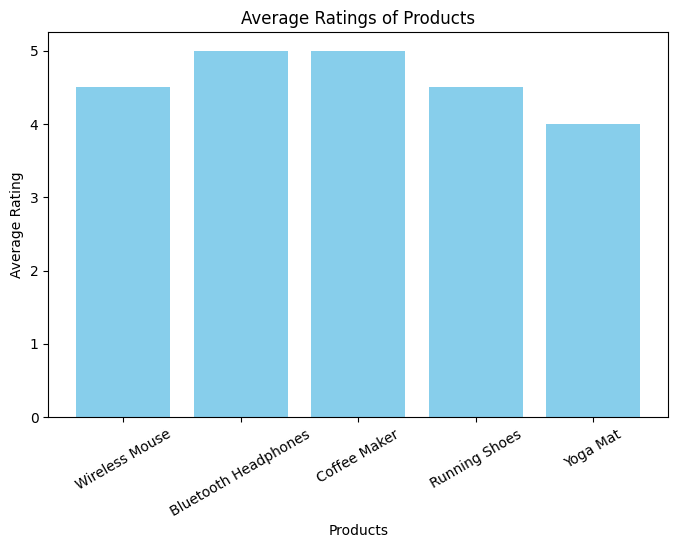

In [6]:
avg_ratings = ratings.groupby("product_id")["rating"].mean()
avg_ratings = avg_ratings.reset_index().merge(products, on="product_id")

plt.figure(figsize=(8,5))
plt.bar(avg_ratings["name"], avg_ratings["rating"], color="skyblue")
plt.title("Average Ratings of Products")
plt.xlabel("Products")
plt.ylabel("Average Rating")
plt.xticks(rotation=30)
plt.show()
